In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def count_mass(p, triple):
    m = np.eye(3)
    m[0][0] = triple[0][0]
    m[0][1] = triple[1][0]
    m[0][2] = triple[2][0]
    m[1][0] = triple[0][1]
    m[1][1] = triple[1][1]
    m[1][2] = triple[2][1]
    m[2] = np.ones(3)
    b = np.array([p[0], p[1], 1])
    return np.linalg.inv(m) @ b

In [3]:
def is_inside(p, p1, p2, p3):
    try:
        mass = count_mass(p, [p1, p2, p3])
    except:
        return False
    return np.all(0 <= mass) and np.all(mass <= 1)

In [4]:
def get_ordered_list(l, point):
    l_copy = l.tolist()
    l_copy.sort(key = lambda p: (p[0] - point[0])**2 + (p[1] - point[1])**2)
    return l_copy

In [5]:
# если треугольника не нашлось, возвращает None
def find_triangle(l, point):
    ord_l = l.tolist()
    ord_l.sort(key = lambda p: (p[0] - point[0])**2 + (p[1] - point[1])**2)
    arr = [(p[0] - point[0])**2 + (p[1] - point[1])**2 for p in l]
    args = np.argsort(arr)
    for index_3 in range(2, len(l)):
        for index_1 in range(0, index_3):
            for index_2 in range(index_1, index_3):
                if is_inside(point, ord_l[index_1], ord_l[index_2], ord_l[index_3]):
                    return [args[index_1], args[index_2], args[index_3]]
    return None

In [6]:
#собственно функцию построения образов по эталонным парам
def f(X, Y, point):
    neighbors_index = find_triangle(X, point)
    if neighbors_index is None:
        return None
    m1, m2, m3 = count_mass(point, X[neighbors_index])
    a, b, c = Y[neighbors_index]
    return tuple(map(sum, zip(a * m1, b * m2, c * m3)))

Протестируем функцию на рандомно сгенерированных множествах. Синие точки - эталонные, они поворачиваются на $10^{\circ}$. Образы красных точек получаем с помощью функции f по синим точкам.

In [7]:
size = 300
N = 50

img = np.ones((size,size,3), dtype=np.uint8) * 255

rng = np.random.default_rng()
base_points = rng.integers(low=30, high=size, size=(N, 2))
test_points = rng.integers(low=50, high=size - 20, size=(N // 5, 2))

for point in base_points:
    cv.circle(img, (point[0],point[1]), radius=3, color=(0, 0, 255), thickness=-1)
    
for point in test_points:
    cv.circle(img, (point[0],point[1]), radius=3, color=(255, 0, 0), thickness=-1)

In [8]:
theta = np.radians(10)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

rotated_base_points = (R @ base_points.T).T
rotated_base_points = np.array(np.round_(rotated_base_points), dtype='int')

In [9]:
test_points_f = []

for test_point in test_points:
    test_points_f.append(f(base_points, rotated_base_points, test_point))

rotated_img = np.ones((size,size,3), dtype=np.uint8) * 255

for point in rotated_base_points:
    cv.circle(rotated_img, (point[0],point[1]), radius=3, color=(0, 0, 255), thickness=-1)

for point in test_points_f:
    
    cv.circle(rotated_img, (int(point[0]),int(point[1])), radius=3, color=(255, 127, 0), thickness=-1)

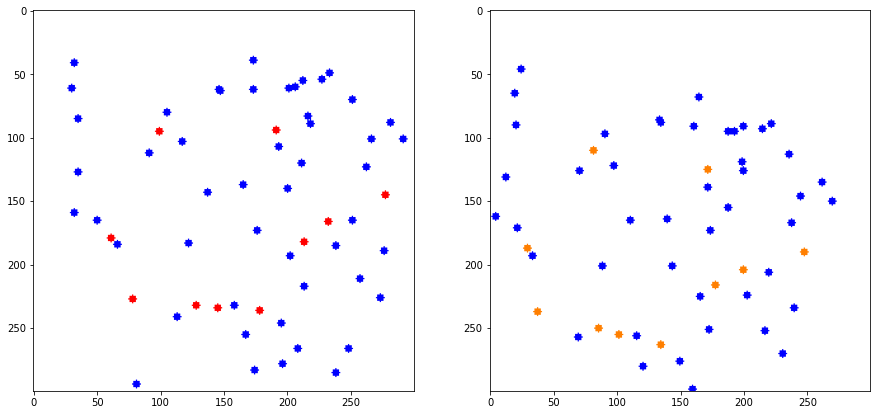

In [10]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 8))
axarr[0].imshow(img)
axarr[1].imshow(rotated_img)

_Комментарий._ Видим, что образы соотвестствуют реальному преобразованию, значит функция работает корректно.

Теперь запустим функцию на картинках _origin.jpg_ и _rec.jpg_. Эталонные соответствия находятся в файле _dot_pairs.csv_ Для примера будем работать не со всеми найденными парами, а только с N = 20 у которых наименьший distance.

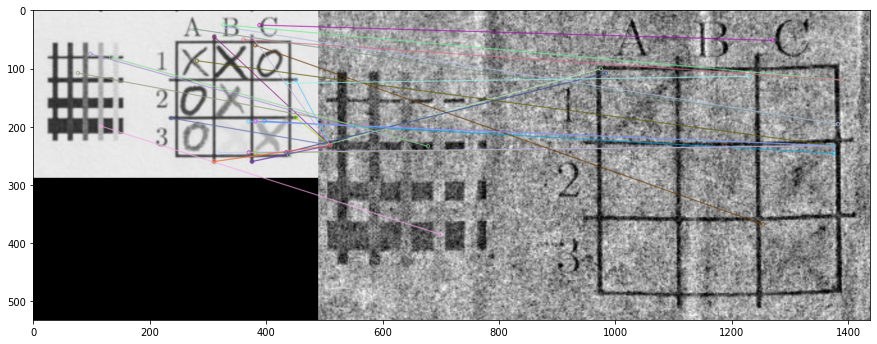

(<matplotlib.image.AxesImage at 0x155e23490>, None)

In [11]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('origin.jpg', cv.IMREAD_GRAYSCALE)
img2 = 255 - cv.imread('rec.jpg', cv.IMREAD_GRAYSCALE)

sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher()

matches = bf.match(des1,des2)

matches = sorted(matches, key = lambda x:x.distance)
pairs = [ (kp1[match.queryIdx].pt, kp2[match.trainIdx].pt) for match in matches ]

N = 30

img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:N],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize =(15, 8)) 
    
plt.imshow(img3),plt.show()

Загрузим эталонные соответствия из файла и построим образы найденных sift-ом точек на _origin.jpg_

In [12]:
import pandas as pd

data = pd.read_csv('dot_pairs.csv')
data.head()

,x1,y1,x2,y2
0,37,79,38,156
1,36,212,38,411
2,142,79,259,153
3,116,213,208,410
4,247,54,480,97


In [13]:
X = []
Y = []

for i, row in data.iterrows():
    X.append([row['x1'], row['y1']])
    Y.append([row['x2'], row['y2']])

X = np.array(X)
Y = np.array(Y)

Посмотрим на эталонные точки:

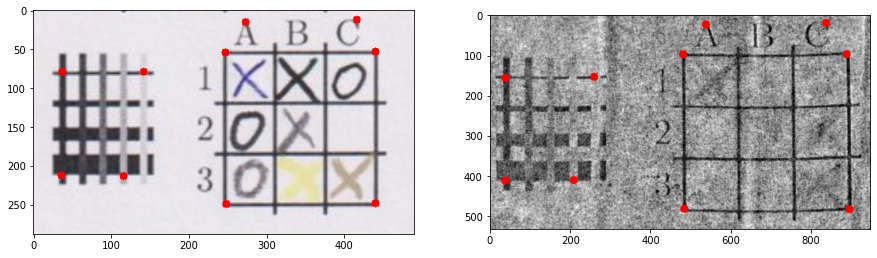

In [14]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 8))

img_1 = cv.imread("origin.jpg")
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)

for p in X:
    cv.circle(img_1, p, 5, (255, 0, 0), -1)

axarr[0].imshow(img_1)

img_2 = 255 - cv.imread("rec.jpg")
img_2 = cv.cvtColor(img_2, cv.COLOR_BGR2RGB)

for p in Y:
    cv.circle(img_2, p, 10, (255, 0, 0), -1)

axarr[1].imshow(img_2)

Наконец построим образы точек, найденных sift-ом и посмотрим, насколько они близки к сопоставленным им точкам.

In [15]:
keypoints_x = [ pair[0] for pair in pairs[:N] ]
keypoints_y = [ pair[1] for pair in pairs[:N] ]

keypoints_x_im = []
for point in keypoints_x:
    keypoints_x_im.append(f(X, Y, point))

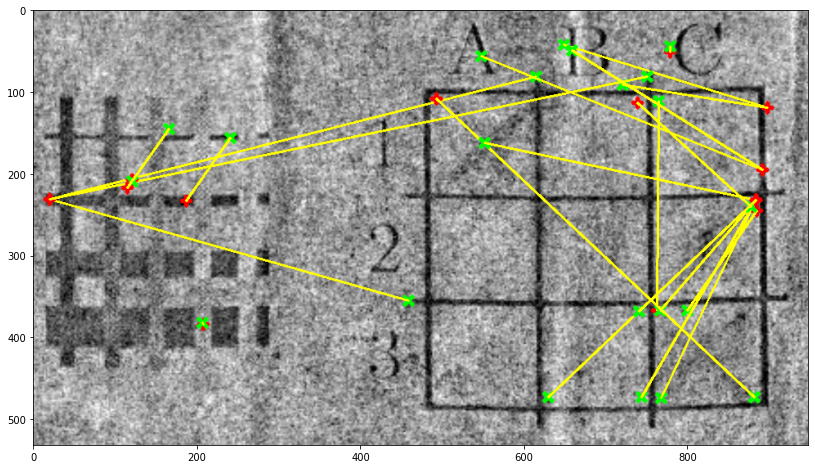

In [16]:
from PIL import Image

img_2 = 255 - cv.imread("rec.jpg")

for p, true_p in zip(keypoints_y, keypoints_x_im):
    if true_p is None:
        continue
    round_p = (int(p[0]), int(p[1]))
    round_true_p = (int(true_p[0]), int(true_p[1]))
    cv.drawMarker(img_2, round_p, color=(255, 0, 0), thickness=3,
        markerType= cv.MARKER_CROSS, line_type=cv.LINE_AA, markerSize=12)
    cv.drawMarker(img_2, round_true_p, color=(0, 255, 0), thickness=3,
        markerType= cv.MARKER_TILTED_CROSS, line_type=cv.LINE_AA, markerSize=10)
    cv.line(img_2,round_p,round_true_p,(255,255,0),2)

plt.figure(figsize =(15, 8)) 
img = Image.fromarray(img_2)
plt.imshow(img_2)

На картинке выше красным изображены точки, полученные sift-ом на картинке _rec.jpg_, а зелёным - образы первых элементов из их пар, полученные на основе эталонных соответствий с помощью функции f.